In [ ]:
# This is a code block from GOSDT with Guesses included so that the cut function can
# be called later to reuse the thresholds
import numpy as np
import pandas as pd
import json
import time
import random
import sys
import os
from queue import Queue
import pathlib

from math import ceil
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics


# fit the tree using gradient boosted classifier
def fit_boosted_tree(X, y, n_est=10, lr=0.1, d=1):
    clf = GradientBoostingClassifier(loss='log_loss',
                                     learning_rate=lr,
                                     n_estimators=n_est,
                                     max_depth=d,
                                     random_state=42)
    clf.fit(X, y)
    out = clf.score(X, y)
    return clf, out


# perform cut on the dataset
def cut(X, ts):
    df = X.copy()
    colnames = X.columns
    for j in range(len(ts)):
        for s in range(len(ts[j])):
            # Create column to store binary values set all to 1
            X[colnames[j]+'<='+str(ts[j][s])] = 1
            # Create mask of observations greater than threshold
            k = df[colnames[j]] > ts[j][s]
            # All observations greater than threshold set to 0
            X.loc[k, colnames[j]+'<='+str(ts[j][s])] = 0
        # Drop feature column after iterating through
        X = X.drop(colnames[j], axis=1)
    # Return a df of all thresholds for each feature binarized
    return X


# Compute the thresholds for Guessing
def get_thresholds(X, y, n_est, lr, d, backselect=True):
    # flatten the array
    y = np.ravel(y)
    # call the fit_boosted_tree function which takes a df X,
    # its class labels y, the number of estimator trees n_est,
    # the learning rate lr, and the max depth d and trains a
    # Gradient Boosting Classifier returning the accuracy and
    # classifier object, backselect removes all but the most
    # accurate threshold for each feature
    clf, out = fit_boosted_tree(X, y, n_est, lr, d)
    # Create an empty list to store lists of threshold values
    # for each feature
    thresholds = []
    # Loop through the columns in X
    for j in range(X.shape[1]):
        # Empty the array for storing estimator threshold values
        tj = np.array([])
        # Iterate through all estimator trees in the black box
        for i in range(len(clf.estimators_)):
            # Store the array of features for each estimator tree
            # (at depth 1, 1 feature)
            f = clf.estimators_[i,0].tree_.feature
            # Store the array of threshold values for each estimator tree
            t = clf.estimators_[i,0].tree_.threshold
            # Append the threshold value to tj if its the current feature
            # in X (j)
            tj = np.append(tj, t[f==j])
        # Remove duplicate threshold values for the current feature
        tj = np.unique(tj)
        # Append the list of thresholds for the current feature to threshold list
        thresholds.append(tj.tolist())
    # Create a binarized df with all thresholds used in black box estimators
    X_new = cut(X, thresholds)
    clf1, out1 = fit_boosted_tree(X_new, y, n_est, lr, d)

    # Set starting accuracy comparison to 1
    outp = 1
    # Copy the black box threshold binarized df
    Xp = X_new.copy()
    # Copy the classifier trained on the binarized data
    clfp = clf1
    # set column tracker to 0
    itr=0
    if backselect:
        # Iterate while there is no drop in accuracy from removing the lowest importance variable
        # compared to the tree trained on all threshold splits (or you run out of columns to drop)
        while outp >= out1 and itr < X_new.shape[1]-1:
            # Get variable importance array from black box
            vi = clfp.feature_importances_
            # Check if there is at least 1 variable importance value
            if vi.size > 0:
                # Get the columns in Xp
                c = Xp.columns
                # Get index of lowest importance variable
                i = np.argmin(vi)
                # Drop lowest importance variable
                Xp = Xp.drop(c[i], axis=1)
                # Retrain/fit black box on reduced data
                clfp, outp = fit_boosted_tree(Xp, y, n_est, lr, d)
                # Increment the iteration counter
                itr += 1
            # Loop will break once the accuracy is reduced below the baseline
            # accuracy from removing variables or if there are no variables left to reduce
            else:
                break
        # Copy the reduced feature set
        Xp[c[i]] = X_new[c[i]]
        #_, _ = fit_boosted_tree(Xp, y, n_est, lr, d)

    h = Xp.columns
    #print('features:', h)
    return Xp, thresholds, h

# compute the thresholds
def compute_thresholds(X, y, n_est, max_depth) :
    # n_est, max_depth: GBDT parameters
    # set LR to 0.1
    lr = 0.1
    start = time.perf_counter()
    X, thresholds, header = get_thresholds(X, y, n_est, lr, max_depth, backselect=True)
    guess_time = time.perf_counter()-start
    return X, thresholds, header, guess_time


In [ ]:
pip install pydotplus

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# import statements, note some of the data cleaning imports aren't needed for this dataset
import pandas as pd
import numpy as np
import pathlib
import gosdt
import time
from sklearn.ensemble import GradientBoostingClassifier
# from imblearn.over_sampling import SMOTE
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import Binarizer


In [ ]:
# Read in the csv for the Wisconsin Breast Cancer Dataset
df = pd.read_csv("diabetes_data_final_file.csv")
# Create a list of the table headers to be used to add headers to training/testing datasets
h = df.columns[:-1]
# Create a series of ground truth target classes
y = df['Outcome_1']
# Drop the target class column to separate the features
X = df.drop(columns=['Outcome_1'])
print(df)


      age    bmi  Glucose  Insulin  HbA1c_level  Pregnancies  hypertension  \
0    73.0  26.62      148        0          5.0            6             0   
1    35.0  27.32       85        0          4.5            1             0   
2    38.0  27.32      183        0          6.2            8             0   
3    75.0  31.11       89       94          6.2            1             0   
4    51.0  39.57      137      168          6.2            0             0   
..    ...    ...      ...      ...          ...          ...           ...   
763  46.0  39.13      101      180          6.5           10             0   
764  14.0  25.53      122        0          4.0            2             0   
765  54.0  27.32      121      112          6.1            5             0   
766  12.0  17.44      126        0          6.5            1             0   
767  59.0  29.46       93        0          4.8            1             0   

     BloodPressure  SkinThickness  heart_disease  smoking_histo

In [ ]:
# Check the class balance
df['Outcome_1'].value_counts()

0    500
1    268
Name: Outcome_1, dtype: int64

In [ ]:
# import for train/test split
from sklearn.model_selection import train_test_split

# Create a 80/20 train test split for validation of the trained model
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [ ]:
import pandas as pd
import time
import pathlib
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import gosdt  # Assuming you have the GOSDT library

# GBDT parameters for threshold and lower bound guesses
n_est = 200
max_depth = 1

# Guess thresholds
X = pd.DataFrame(X_train, columns=h)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Guess thresholds
X_train_g, thresholds, header, threshold_guess_time = compute_thresholds(X_train, y_train, n_est, max_depth)
y_train_g = pd.DataFrame(y_train)

# Guess lower bound using Gradient Boosting
start_time = time.time()
clf = GradientBoostingClassifier(n_estimators=n_est, max_depth=max_depth, random_state=42)
clf.fit(X_train_g, y_train_g.values.flatten())
warm_labels = clf.predict(X_train_g)
elapsed_time = time.time() - start_time
lb_time = elapsed_time

# Save the labels from lower bound guesses to a tmp file
labelsdir = pathlib.Path('/tmp/warm_lb_labels')
labelsdir.mkdir(exist_ok=True, parents=True)
labelpath = labelsdir / 'warm_label.tmp'
labelpath = str(labelpath)
pd.DataFrame(warm_labels, columns=["class_labels"]).to_csv(labelpath, header="class_labels", index=None)

# Train GOSDT model
config = {
    "regularization": 0.001,
    "depth_budget": 3,
    "warm_LB": True,
    "path_to_labels": labelpath,
    "similar_support": False
}

model = gosdt.GOSDT(config)
model.fit(X_train_g, y_train_g)

print("Evaluating the model, extracting tree and scores...\n", flush=True)

# Get the results for training accuracy
train_acc = model.score(X_train_g, y_train_g)

# Threshold X_test using the same black-box derived thresholds as the training set
X_test = cut(X_test, thresholds)  # Apply same thresholds to the test set
X_test = X_test[X_train_g.columns]  # Remove unused thresholds

# Calculate test accuracy
test_acc = model.score(X_test, y_test)

# Get number of leaves and nodes in the model
n_leaves = model.leaves()
n_nodes = model.nodes()

# Calculate total training time
fulltime = time.time() - start_time

# Print training time and model structure
print("Model training time: {}".format(fulltime))
print("Training accuracy: {}".format(train_acc))
print("Test accuracy: {}".format(test_acc))
print("# of leaves: {}".format(n_leaves))
print("# of nodes: {}".format(n_nodes))

# Print the confusion matrix of the model (if available)
print("Confusion Matrix (Training Set):")
train_preds = model.predict(X_train_g)
train_cm = confusion_matrix(y_train_g, train_preds)
print(train_cm)

print("Confusion Matrix (Test Set):")
test_preds = model.predict(X_test)
test_cm = confusion_matrix(y_test, test_preds)
print(test_cm)

# Calculate precision, recall, F1 score, and support for the training set
train_prec, train_rec, train_fbeta, train_supp = precision_recall_fscore_support(
    y_train_g, train_preds, average='binary'
)

# Calculate precision, recall, F1 score, and support for the test set
test_prec, test_rec, test_fbeta, test_supp = precision_recall_fscore_support(
    y_test, test_preds, average='binary'
)

# Print metrics in the desired order: Precision, Accuracy, Recall
print("\n--- Training Set Metrics ---")
print(f"Training Precision: {train_prec:.4f}")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Training Recall: {train_rec:.4f}")
print(f"Training F1-Score: {train_fbeta:.4f}")
print(f"Training Support: {train_supp}")

print("\n--- Test Set Metrics ---")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1-Score: {test_fbeta:.4f}")
print(f"Test Support: {test_supp}")

# Final output
print("\n--- Final Results ---")
print(f"Model Training Time: {fulltime:.2f} seconds")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"# of Leaves: {n_leaves}")
print(f"# of Nodes: {n_nodes}")
print(f"Confusion Matrix (Training Set):\n{train_cm}")
print(f"Confusion Matrix (Test Set):\n{test_cm}")



X_train shape: (614, 13)
y_train shape: (614,)
Regularization smaller than 1/(num_samples) - this may lead to longer training time if not adjusted.
Regularization increased to 1/(num_samples) = 0. To allow regularization below this, set allow_small_reg to true
gosdt reported successful execution
training completed. 0.000/0.000/0.011 (user, system, wall), mem=0 MB
bounds: [0.236156..0.236156] (0.000000) loss=0.229642, iterations=111
Evaluating the model, extracting tree and scores...

Model training time: 0.40955686569213867
Training accuracy: 0.7703583061889251
Test accuracy: 0.7467532467532467
# of leaves: 4
# of nodes: 7
Confusion Matrix (Training Set):
[[369  32]
 [109 104]]
Confusion Matrix (Test Set):
[[86 13]
 [26 29]]

--- Training Set Metrics ---
Training Precision: 0.7647
Training Accuracy: 0.7704
Training Recall: 0.4883
Training F1-Score: 0.5960
Training Support: None

--- Test Set Metrics ---
Test Precision: 0.6905
Test Accuracy: 0.7468
Test Recall: 0.5273
Test F1-Score: 0.5

In [ ]:
""""import pandas as pd
import numpy as np
import time
import pathlib
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
import gosdt  # Assuming you have the GOSDT library

# Assuming X_train and y_train are your initial datasets
# Split the dataset into train (70%), and temp (30%) which will be further split into validation (15%) and test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(X_train, y_train, test_size=0.30, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)  # 0.50 * 0.30 = 0.15

# GBDT parameters for threshold and lower bound guesses
n_est = 300
max_depth = 1

# Guess thresholds
X = pd.DataFrame(X_train, columns=h)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train_g, thresholds, header, threshold_guess_time = compute_thresholds(X_train, y_train, n_est, max_depth)
y_train_g = pd.DataFrame(y_train)

# Guess lower bound
start_time = time.time()
clf = GradientBoostingClassifier(n_estimators=n_est, max_depth=max_depth, random_state=42)
clf.fit(X_train_g, y_train_g.values.flatten())
warm_labels = clf.predict(X_train_g)
elapsed_time = time.time() - start_time
lb_time = elapsed_time

# Save the labels from lower bound guesses as a tmp file and return the path to it.
labelsdir = pathlib.Path('/tmp/warm_lb_labels')
labelsdir.mkdir(exist_ok=True, parents=True)
labelpath = labelsdir / 'warm_label.tmp'
labelpath = str(labelpath)
pd.DataFrame(warm_labels, columns=["class_labels"]).to_csv(labelpath, header="class_labels", index=None)

# Train GOSDT model
config = {
    "regularization": 0.01,
    "depth_budget": 5,
    "warm_LB": True,
    "path_to_labels": labelpath,
    "similar_support": False
}

model = gosdt.GOSDT(config)
model.fit(X_train_g, y_train_g)

# Lists to store metrics and leaves/nodes for each fold and final evaluation
train_accuracy_list = []
train_precision_list = []
train_recall_list = []
train_leaves_list = []
train_nodes_list = []

test_accuracy_list = []
test_precision_list = []
test_recall_list = []
test_leaves_list = []
test_nodes_list = []

# Get the results
train_acc = model.score(X_train_g, y_train_g)
train_preds = model.predict(X_train_g)
train_precision = precision_score(y_train_g, train_preds, average='macro')
train_recall = recall_score(y_train_g, train_preds, average='macro')
train_leaves = model.leaves()
train_nodes = model.nodes()

# Threshold X_val using the same black box derived thresholds as the training set
X_val_g = cut(X_val, thresholds)  # Apply same thresholds
X_val_g = X_val_g[X_train_g.columns]  # Remove unused thresholds
val_acc = model.score(X_val_g, y_val)  # Calculate validation accuracy
val_preds = model.predict(X_val_g)
val_precision = precision_score(y_val, val_preds, average='macro')
val_recall = recall_score(y_val, val_preds, average='macro')

# Threshold X_test using the same black box derived thresholds as the training set
X_test_g = cut(X_test, thresholds)  # Apply same thresholds
X_test_g = X_test_g[X_train_g.columns]  # Remove unused thresholds
test_acc = model.score(X_test_g, y_test)  # Calculate test accuracy
test_preds = model.predict(X_test_g)
test_precision = precision_score(y_test, test_preds, average='macro')
test_recall = recall_score(y_test, test_preds, average='macro')
test_leaves = model.leaves()
test_nodes = model.nodes()

# Store metrics for each fold
train_accuracy_list.append(train_acc)
train_precision_list.append(train_precision)
train_recall_list.append(train_recall)
train_leaves_list.append(train_leaves)
train_nodes_list.append(train_nodes)

test_accuracy_list.append(test_acc)
test_precision_list.append(test_precision)
test_recall_list.append(test_recall)
test_leaves_list.append(test_leaves)
test_nodes_list.append(test_nodes)

# Print the metrics for this fold
print(f'Fold Metrics: ')
print(f"Training Accuracy: {train_acc:.4f}, Training Precision (macro): {train_precision:.4f}, Training Recall (macro): {train_recall:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}, Validation Precision (macro): {val_precision:.4f}, Validation Recall (macro): {val_recall:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test Precision (macro): {test_precision:.4f}, Test Recall (macro): {test_recall:.4f}")
print(f"Training Leaves: {train_leaves}, Training Nodes: {train_nodes}")
print(f"Test Leaves: {test_leaves}, Test Nodes: {test_nodes}")

# Final evaluation on the test set using the best regularization from the validation
# Assuming best model found during cross-validation
best_reg = 0.005  # Using fixed regularization for simplicity
final_model = gosdt.GOSDT({"regularization": best_reg, "depth_budget": 5})
final_model.fit(X_train, y_train)

# Final test evaluation on the test set
test_preds_final = final_model.predict(X_test)
test_acc_final = accuracy_score(y_test, test_preds_final)
test_precision_final = precision_score(y_test, test_preds_final, average='macro')
test_recall_final = recall_score(y_test, test_preds_final, average='macro')
test_leaves_final = final_model.leaves()
test_nodes_final = final_model.nodes()

# Print final evaluation results
print(f'\n--- Final Test Set Evaluation ---')
print(f'Final Test Accuracy: {test_acc_final:.4f}')
print(f'Final Test Precision (macro): {test_precision_final:.4f}')
print(f'Final Test Recall (macro): {test_recall_final:.4f}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test, test_preds_final)}')
print(f"Final Test Leaves: {test_leaves_final}, Final Test Nodes: {test_nodes_final}")

# Print all metrics together at the end
print("\n--- Summary of All Metrics ---")
print(f"Average Training Accuracy: {sum(train_accuracy_list) / len(train_accuracy_list):.4f}")
print(f"Average Training Precision (macro): {sum(train_precision_list) / len(train_precision_list):.4f}")
print(f"Average Training Recall (macro): {sum(train_recall_list) / len(train_recall_list):.4f}")
print(f"Average Training Leaves: {sum(train_leaves_list) / len(train_leaves_list):.0f}")
print(f"Average Training Nodes: {sum(train_nodes_list) / len(train_nodes_list):.0f}")

print(f"Average Test Accuracy: {sum(test_accuracy_list) / len(test_accuracy_list):.4f}")
print(f"Average Test Precision (macro): {sum(test_precision_list) / len(test_precision_list):.4f}")
print(f"Average Test Recall (macro): {sum(test_recall_list) / len(test_recall_list):.4f}")
print(f"Average Test Leaves: {sum(test_leaves_list) / len(test_leaves_list):.0f}")
print(f"Average Test Nodes: {sum(test_nodes_list) / len(test_nodes_list):.0f}")



X_train shape: (214, 13)
y_train shape: (214,)


In [ ]:
"""""import pandas as pd
import numpy as np
import time
import pathlib
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import gosdt  # Assuming you have the GOSDT library

# Assuming X_train and y_train are your initial datasets
X_temp, X_test, y_temp, y_test = train_test_split(X_train, y_train, test_size=0.30, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)  # 0.50 * 0.30 = 0.15

# GBDT parameters
n_est = 300
max_depth = 1

X = pd.DataFrame(X_train, columns=h)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Threshold computation
X_train_g, thresholds, header, threshold_guess_time = compute_thresholds(X_train, y_train, n_est, max_depth)
y_train_g = pd.DataFrame(y_train)

# Time the Gradient Boosting Classifier training
start_time_gbc = time.time()
clf = GradientBoostingClassifier(n_estimators=n_est, max_depth=max_depth, random_state=42)
clf.fit(X_train_g, y_train_g.values.flatten())
warm_labels = clf.predict(X_train_g)
elapsed_time_gbc = time.time() - start_time_gbc

# Save warm labels as tmp file
labelsdir = pathlib.Path('/tmp/warm_lb_labels')
labelsdir.mkdir(exist_ok=True, parents=True)
labelpath = labelsdir / 'warm_label.tmp'
labelpath = str(labelpath)
pd.DataFrame(warm_labels, columns=["class_labels"]).to_csv(labelpath, header="class_labels", index=None)

# Train GOSDT model
config = {
    "regularization": 0.005,
    "depth_budget": 5,
    "warm_LB": True,
    "path_to_labels": labelpath,
    "similar_support": False
}

model = gosdt.GOSDT(config)
start_time_gosdt = time.time()
model.fit(X_train_g, y_train_g)
elapsed_time_gosdt = time.time() - start_time_gosdt

# Evaluate the model
train_acc = model.score(X_train_g, y_train_g)

# Threshold X_val and X_test
X_val_g = cut(X_val, thresholds)
X_val_g = X_val_g[X_train_g.columns]
val_acc = model.score(X_val_g, y_val)

X_test_g = cut(X_test, thresholds)
X_test_g = X_test_g[X_train_g.columns]
test_acc = model.score(X_test_g, y_test)

# Get predictions and metrics
test_preds = model.predict(X_test_g)
test_precision = precision_score(y_test, test_preds, average='macro')
test_recall = recall_score(y_test, test_preds, average='macro')
test_f1 = f1_score(y_test, test_preds, average='macro')
cm = confusion_matrix(y_test, test_preds)

# Print metrics
print("Model training time: {}".format(time.time() - start_time))
print(f"Gradient Boosting Classifier training time: {elapsed_time_gbc:.2f} seconds")
print(f"GOSDT model training time: {elapsed_time_gosdt:.2f} seconds")
print("Training accuracy: {}".format(train_acc))
print("Validation accuracy: {}".format(val_acc))
print("Test accuracy: {}".format(test_acc))
print("# of leaves: {}".format(model.leaves()))
print("# of nodes: {}".format(model.nodes()))
print(f"Test Precision (macro): {test_precision:.4f}")
print(f"Test Recall (macro): {test_recall:.4f}")
print(f"Test F1 Score (macro): {test_f1:.4f}")
print(f"Confusion Matrix:\n{cm}")


X_train shape: (214, 13)
y_train shape: (214,)
gosdt reported successful execution
training completed. 0.000/0.000/5.021 (user, system, wall), mem=0 MB
bounds: [0.176822..0.176822] (0.000000) loss=0.116822, iterations=94222


NameError: name 'start_time' is not defined

In [ ]:
print(X_train_g.columns)

Index(['Pregnancies_4<=0.5', 'Pregnancies_6<=0.5', 'Pregnancies_7<=0.5',
       'Pregnancies_8<=0.5', 'Pregnancies_9<=0.5', 'Pregnancies_10<=0.5',
       'Pregnancies_16<=0.5', 'smoking_1<=0.5', 'smoking_2<=0.5',
       'smoking_4<=0.5', 'Glucose_binarized<=0.5',
       'SkinThickness_binarized<=0.5', 'Insulin_binarized<=0.5',
       'smoking_3<=0.5'],
      dtype='object')


In [ ]:
# Get precision, recall, and f1 score
from sklearn.metrics import precision_recall_fscore_support
y_train_pred = model.predict(X_train_g)
y_test_pred = model.predict(X_test)
prec, rec, fbeta, supp = precision_recall_fscore_support(y_train_g, y_train_pred, average='binary')
prec2, rec2, fbeta2, supp2 = precision_recall_fscore_support(y_test, y_test_pred, average='binary')

/home/msr216/.conda/envs/dimacs2024/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(prec2)
print(rec2)
print(fbeta2)

0.0
0.0
0.0


In [ ]:
#Display the confusion matrix for the training and test set
from sklearn.metrics import confusion_matrix
display(confusion_matrix(y_train_g,y_train_pred))
display(confusion_matrix(y_test,y_test_pred))

array([[129,  14],
       [ 37,  34]])

array([[124,   0],
       [ 61,   0]])

In [ ]:
# Create a fresh df
df = pd.read_csv("compas.csv")
h = df.columns[:-1]
y = df['two_year_recid']
X = df.drop(columns=['two_year_recid'])


In [ ]:
# Create a fresh train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
# Train a black box Gradient Boosting Decision Tree Classifier to compare to GOSDT
n_est = 250
d = 10
lr = 0.001

clf = GradientBoostingClassifier(loss='log_loss',learning_rate=lr,n_estimators=n_est,max_depth=d,random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
out = clf.score(X_train, y_train)
print(out)

0.7227149321266968


In [ ]:
# Calculate test accuracy
y_test_pred =  clf.predict(X_test)
print(clf.score(X_test,y_test))

0.6157742402315485


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.580409 to fit



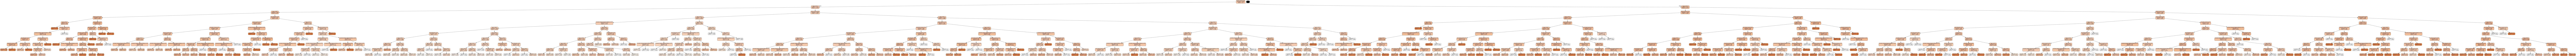

In [ ]:
# Display an example tree from the ensemble
tree = clf.estimators_[0,0]

from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image

dot_data = export_graphviz(
    tree, out_file = None, filled = True, rounded = True,
    special_characters = True,
    proportion = False, impurity = False,
    feature_names = X_train.columns)

graph = graph_from_dot_data(dot_data)
png=graph.create_png()
from pathlib import Path

Path('./out.png').write_bytes(png)
Image(png)

array([0.76451451, 0.91557996])

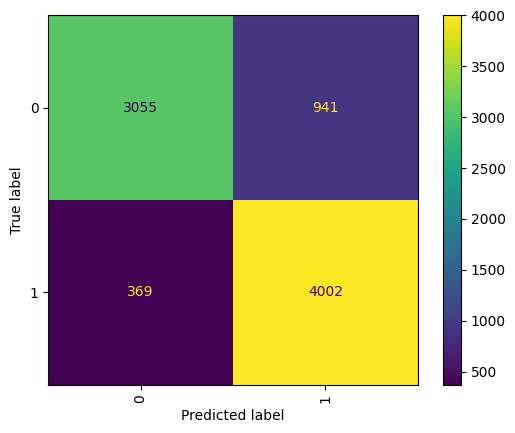

In [ ]:
# Generate a confusion matrix for the GBDT
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = confusion_matrix(y_train, y_pred)
ConfusionMatrixDisplay.from_estimator(clf,X_train,y_train,display_labels=clf.classes_,xticks_rotation='vertical')
matrix.diagonal()/matrix.sum(axis=1)

In [ ]:
# Calculate precision, recall and f1
from sklearn.metrics import precision_recall_fscore_support
prec, rec, fbeta, supp = precision_recall_fscore_support(y_test, y_test_pred)

In [ ]:
classes = clf.classes_
d = {'Class':classes,'Precision':prec,'Recall':rec,'f1':fbeta,'Support':supp}
scores_df = pd.DataFrame(d)
display(scores_df)

,Class,Precision,Recall,f1,Support
0,0,0.685298,0.561753,0.617406,1004
1,1,0.653270,0.761949,0.703437,1088


In [ ]:
# Create a df from the thresholded GOSDT training set
xt_df = pd.DataFrame(X_train_g)
xt_df = pd.concat([xt_df,y_train_g], axis = 1)
xt_df

,sex=female<=0.5,age<=19.5,age<=20.5,age<=21.5,age<=22.5,age<=27.5,age<=28.5,age<=32.5,age<=34.5,age<=36.5,...,priors_count<=14.5,priors_count<=15.5,priors_count<=19.5,priors_count<=22.5,priors_count<=23.5,priors_count<=34.0,priors_count<=36.5,current_charge_degree=felony<=0.5,juvenile_crimes<=1.5,two_year_recid
5288,1,0,0,0,0,0,0,1,1,1,...,0,0,1,1,1,1,1,1,1,1
1386,1,0,0,0,0,0,1,1,1,1,...,1,1,1,1,1,1,1,0,1,1
784,1,0,0,0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
2331,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
1822,1,0,0,0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
5764,1,0,0,0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,0
452,1,0,0,0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,0,0,0
3413,0,0,0,0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,1


In [ ]:
xt_df


,sex=female<=0.5,age<=19.5,age<=20.5,age<=21.5,age<=22.5,age<=27.5,age<=28.5,age<=32.5,age<=34.5,age<=36.5,...,priors_count<=14.5,priors_count<=15.5,priors_count<=19.5,priors_count<=22.5,priors_count<=23.5,priors_count<=34.0,priors_count<=36.5,current_charge_degree=felony<=0.5,juvenile_crimes<=1.5,two_year_recid
5288,1,0,0,0,0,0,0,1,1,1,...,0,0,1,1,1,1,1,1,1,1
1386,1,0,0,0,0,0,1,1,1,1,...,1,1,1,1,1,1,1,0,1,1
784,1,0,0,0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
2331,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
1822,1,0,0,0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
5764,1,0,0,0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,0
452,1,0,0,0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,0,0,0
3413,0,0,0,0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,1


In [ ]:
# Import RID, all RID files must be in the same level of the directory as the Jupyter Notebook
# RID is very resource hungry, make sure you have enough compute to support your lam and eps!
from rashomon_importance_distribution import RashomonImportanceDistribution
start_time = time.time()
# Map the threshold columns, thresholds from the same feature are grouped to calculate feature importance
mapping={
    0:[0],
    1:[1,2,3,4,5,6,7,8,9],
    2:[10,11,12,13,14,15,16],
    3:[17],
    4:[18],
    5:[19]
}

# Set parameters for RID, db is depth budget, lam is the lambda or sparsity hyperparameter,
# eps is the epsilon or confidence range for model inclusion around the optimal model
RID = RashomonImportanceDistribution(
    input_df = xt_df,
    binning_map = mapping,
    db = 0,
    lam = 0.01,
    eps = 0.005,
    vi_metric = 'sub_mr',
    dataset_name = 'compas',
    n_resamples = 10,
    verbose = True,
    max_par_for_gosdt = 3
)

# Print the variable importance metrics from RID
for v in range(15):
    print(f'Variable {v} ------------')

    print('Box and whiskers mean:', RID.mean(v))
    print('Box and whiskers median:', RID.median(v))
    print('Box and whiskers range:', RID.bwr(v))
    print('--- %s seconds' % (time.time()-start_time))

0
0
0
Using configuration: {
  "balance": false,
  "cancellation": true,
  "continuous_feature_exchange": false,
  "costs": "",
  "covered_sets_thresholds": [],
  "datatset_encoding": "",
  "depth_budget": 0,
  "diagnostics": true,
  "feature_exchange": false,
  "feature_transform": true,
  "look_ahead": true,
  "memory_checkpoints": [],
  "minimum_captured_points": 0,
  "model": "",
  "model_limit": 10000,
  "non_binary": false,
  "output_accuracy_model_set": false,
  "output_covered_sets": [],
  "precision_limit": 0,
  "profile": "",
  "rashomon": true,
  "rashomon_bound": 0.0,
  "rashomon_bound_adder": 0.004999999888241291,
  "rashomon_bound_multiplier": 0.0,
  "rashomon_ignore_trivial_extensions": true,
  "rashomon_model": "",
  "rashomon_model_set_suffix": "_bootstrap_0_eps_0.005_db_0_reg_0.01.json",
  "rashomon_trie": "./cached_files/compas/rashomon_outputs/trie_bootstrap_0_eps_0.005_db_0_reg_0.01.json",
  "regularization": 0.009999999776482582,
  "rule_list": false,
  "similar_s

In [ ]:
# Rerun GOSDT specifying important features to keep to compare to the initial model
dfr = pd.read_csv("diabetes_data_final_file.csv")
print(dfr)

Xr = dfr.drop(columns=['Outcome_1','SkinThickness', 'blood_glucose_level', 'HbA1c_level', 'Insulin', 'smoking_history', 'hypertension', 'heart_disease'])

yr = dfr['Outcome_1']
h = dfr.columns[:-1]
print(Xr.head())

      age    bmi  Glucose  Insulin  HbA1c_level  Pregnancies  hypertension  \
0    73.0  26.62      148        0          5.0            6             0   
1    35.0  27.32       85        0          4.5            1             0   
2    38.0  27.32      183        0          6.2            8             0   
3    75.0  31.11       89       94          6.2            1             0   
4    51.0  39.57      137      168          6.2            0             0   
..    ...    ...      ...      ...          ...          ...           ...   
763  46.0  39.13      101      180          6.5           10             0   
764  14.0  25.53      122        0          4.0            2             0   
765  54.0  27.32      121      112          6.1            5             0   
766  12.0  17.44      126        0          6.5            1             0   
767  59.0  29.46       93        0          4.8            1             0   

     BloodPressure  SkinThickness  heart_disease  smoking_histo

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(Xr, yr, test_size=0.30, random_state=42, stratify=yr)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)



In [ ]:
import pandas as pd
import time
import pathlib
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import gosdt  # Assuming you have the GOSDT library

# GBDT parameters for threshold and lower bound guesses
n_est = 100
max_depth = 1

# Guess thresholds
X = pd.DataFrame(X_train, columns=h)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Guess thresholds
X_train_g, thresholds, header, threshold_guess_time = compute_thresholds(X_train, y_train, n_est, max_depth)
y_train_g = pd.DataFrame(y_train)

# Guess lower bound using Gradient Boosting
start_time = time.time()
clf = GradientBoostingClassifier(n_estimators=n_est, max_depth=max_depth, random_state=42)
clf.fit(X_train_g, y_train_g.values.flatten())
warm_labels = clf.predict(X_train_g)
elapsed_time = time.time() - start_time
lb_time = elapsed_time

# Save the labels from lower bound guesses to a tmp file
labelsdir = pathlib.Path('/tmp/warm_lb_labels')
labelsdir.mkdir(exist_ok=True, parents=True)
labelpath = labelsdir / 'warm_label.tmp'
labelpath = str(labelpath)
pd.DataFrame(warm_labels, columns=["class_labels"]).to_csv(labelpath, header="class_labels", index=None)

# Train GOSDT model
config = {
    "regularization": 0.001,
    "depth_budget": 3,
    "warm_LB": True,
    "path_to_labels": labelpath,
    "similar_support": False
}

model = gosdt.GOSDT(config)
model.fit(X_train_g, y_train_g)

print("Evaluating the model, extracting tree and scores...\n", flush=True)

# Get the results for training accuracy
train_acc = model.score(X_train_g, y_train_g)

# Threshold X_test using the same black-box derived thresholds as the training set
X_test = cut(X_test, thresholds)  # Apply same thresholds to the test set
X_test = X_test[X_train_g.columns]  # Remove unused thresholds

# Start tracking time for testing phase
test_start_time = time.time()

# Calculate test accuracy
test_acc = model.score(X_test, y_test)

# Get number of leaves and nodes in the model
n_leaves = model.leaves()
n_nodes = model.nodes()

# Calculate total training time
fulltime = time.time() - start_time

# Calculate test phase time
test_time = time.time() - test_start_time

# Print training time, test time, and model structure
print("Model training time: {}".format(fulltime))
print("Test time: {}".format(test_time))
print("Training accuracy: {}".format(train_acc))
print("Test accuracy: {}".format(test_acc))
print("# of leaves: {}".format(n_leaves))
print("# of nodes: {}".format(n_nodes))

# Print the confusion matrix of the model (if available)
print(model.confusion)
print(model.tree)

# Predicting for training and test sets
y_train_pred = model.predict(X_train_g)  # Predictions for the training set
y_test_pred = model.predict(X_test)     # Predictions for the test set

# Calculate precision, recall, F1 score, and support for the training set
train_prec, train_rec, train_fbeta, train_supp = precision_recall_fscore_support(
    y_train_g, y_train_pred, average='binary'
)

# Calculate precision, recall, F1 score, and support for the test set
test_prec, test_rec, test_fbeta, test_supp = precision_recall_fscore_support(
    y_test, y_test_pred, average='binary'
)

# Print the results for training and test sets
print(f"Training Precision: {train_prec:.4f}")
print(f"Training Recall: {train_rec:.4f}")
print(f"Training F1 Score: {train_fbeta:.4f}")
print(f"Training Support: {train_supp}")

print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1 Score: {test_fbeta:.4f}")
print(f"Test Support: {test_supp}")

# Confusion Matrix for Training set
train_cm = confusion_matrix(y_train_g, y_train_pred)
print("\nTraining Set Confusion Matrix:")
print(train_cm)

# Confusion Matrix for Test set
test_cm = confusion_matrix(y_test, y_test_pred)
print("\nTest Set Confusion Matrix:")
print(test_cm)# Print the results for training and test sets
print(f"Training Precision: {train_prec:.4f}")
print(f"Training Recall: {train_rec:.4f}")
print(f"Training F1 Score: {train_fbeta:.4f}")
print(f"Training Support: {train_supp}")

print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1 Score: {test_fbeta:.4f}")
print(f"Test Support: {test_supp}")

# Confusion Matrix for Training set
train_cm = confusion_matrix(y_train_g, y_train_pred)
print("\nTraining Set Confusion Matrix:")
print(train_cm)

# Confusion Matrix for Test set
test_cm = confusion_matrix(y_test, y_test_pred)
print("\nTest Set Confusion Matrix:")
print(test_cm)


X_train shape: (268, 6)
y_train shape: (268,)
gosdt reported successful executionRegularization smaller than 1/(num_samples) - this may lead to longer training time if not adjusted.
Regularization increased to 1/(num_samples) = 0. To allow regularization below this, set allow_small_reg to true

training completed. 0.000/0.000/0.001 (user, system, wall), mem=0 MB
bounds: [0.208955..0.208955] (0.000000) loss=0.194030, iterations=27
Evaluating the model, extracting tree and scores...

Model training time: 0.08382868766784668
Test time: 0.0013730525970458984
Training accuracy: 0.8059701492537313
Test accuracy: 0.6753246753246753
# of leaves: 4
# of nodes: 7
<bound method GOSDT.confusion of <gosdt.model.gosdt.GOSDT object at 0x7f8a67bfccd0>>
if Glucose<=112.5 = 1 and bmi<=20.969999313354492 = 1 then:
    predicted class: 0
    misclassification penalty: 0.007
    complexity penalty: 0.004

else if Glucose<=112.5 != 1 and bmi<=20.969999313354492 = 1 then:
    predicted class: 1
    misclassi

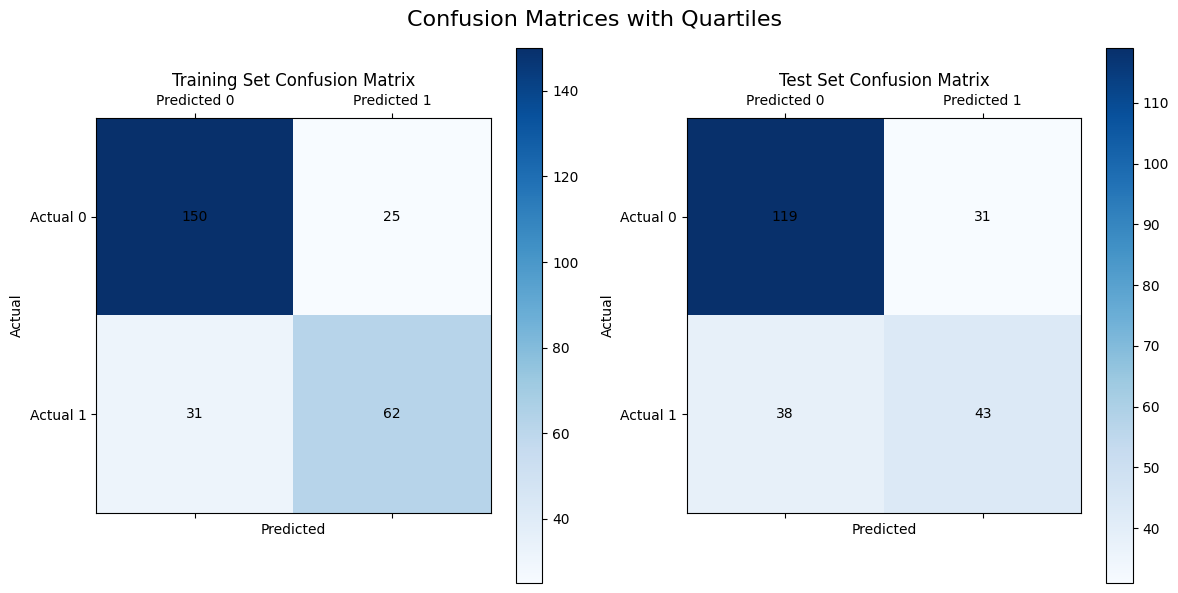

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrices for training and test sets
train_cm = np.array([[150, 25], [31, 62]])  # Example: replace with your actual matrix
test_cm = np.array([[119, 31], [38, 43]])   # Example: replace with your actual matrix

# Calculate quartiles for color scaling
train_min, train_max = train_cm.min(), train_cm.max()
test_min, test_max = test_cm.min(), test_cm.max()

# Create subplots for both confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Training Set Confusion Matrix
cax0 = ax[0].matshow(train_cm, cmap='Blues')
fig.colorbar(cax0, ax=ax[0])
ax[0].set_title('Training Set Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
ax[0].set_xticks([0, 1])
ax[0].set_yticks([0, 1])
ax[0].set_xticklabels(['Predicted 0', 'Predicted 1'])
ax[0].set_yticklabels(['Actual 0', 'Actual 1'])

# Annotate the cells with the confusion matrix values
for i in range(train_cm.shape[0]):
    for j in range(train_cm.shape[1]):
        ax[0].text(j, i, str(train_cm[i, j]), ha='center', va='center', color='black')

# Plot for Test Set Confusion Matrix
cax1 = ax[1].matshow(test_cm, cmap='Blues')
fig.colorbar(cax1, ax=ax[1])
ax[1].set_title('Test Set Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
ax[1].set_xticks([0, 1])
ax[1].set_yticks([0, 1])
ax[1].set_xticklabels(['Predicted 0', 'Predicted 1'])
ax[1].set_yticklabels(['Actual 0', 'Actual 1'])

# Annotate the cells with the confusion matrix values
for i in range(test_cm.shape[0]):
    for j in range(test_cm.shape[1]):
        ax[1].text(j, i, str(test_cm[i, j]), ha='center', va='center', color='black')

# Set the title for the entire figure
plt.suptitle('Confusion Matrices with Quartiles', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()


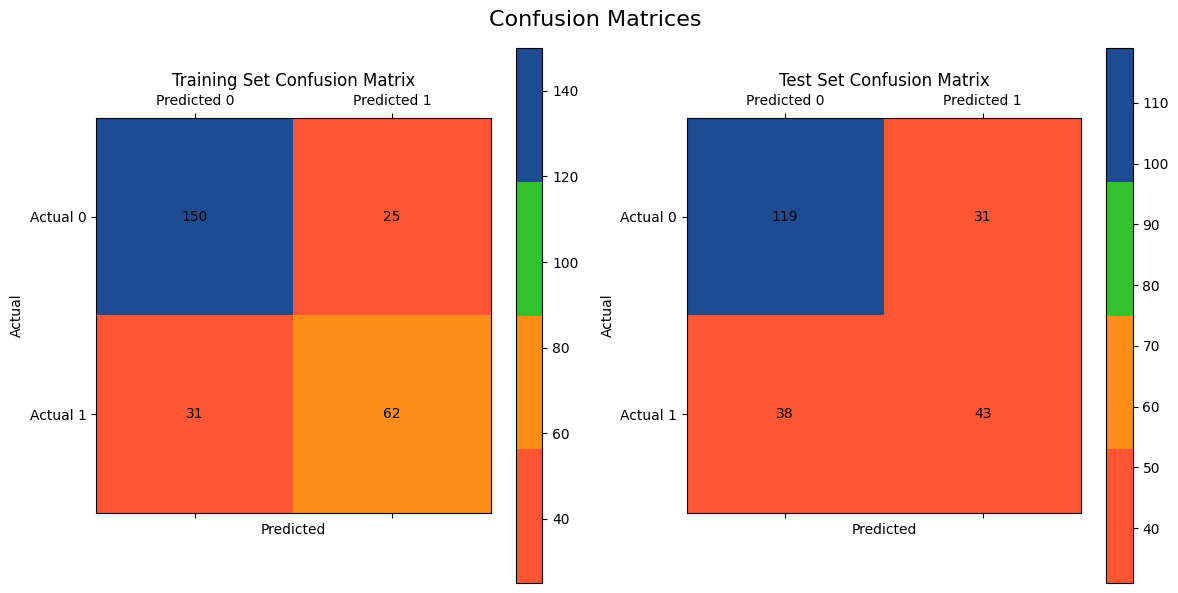

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Confusion matrices for training and test sets
train_cm = np.array([[150, 25], [31, 62]])  # Example: replace with your actual matrix
test_cm = np.array([[119, 31], [38, 43]])   # Example: replace with your actual matrix

# Create a custom colormap with distinct colors for each quartile
# Define colors for each section of the confusion matrix
colors = ["#FF5733", "#FF8D1A", "#32C32C", "#1E4C92"]  # Red for TN, Orange for FP, Green for FN, Blue for TP
cmap = mcolors.ListedColormap(colors)

# Create subplots for both confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Training Set Confusion Matrix with custom colormap
cax0 = ax[0].matshow(train_cm, cmap=cmap)
fig.colorbar(cax0, ax=ax[0])
ax[0].set_title('Training Set Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
ax[0].set_xticks([0, 1])
ax[0].set_yticks([0, 1])
ax[0].set_xticklabels(['Predicted 0', 'Predicted 1'])
ax[0].set_yticklabels(['Actual 0', 'Actual 1'])

# Annotate the cells with the confusion matrix values
for i in range(train_cm.shape[0]):
    for j in range(train_cm.shape[1]):
        ax[0].text(j, i, str(train_cm[i, j]), ha='center', va='center', color='black')

# Plot for Test Set Confusion Matrix with custom colormap
cax1 = ax[1].matshow(test_cm, cmap=cmap)
fig.colorbar(cax1, ax=ax[1])
ax[1].set_title('Test Set Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
ax[1].set_xticks([0, 1])
ax[1].set_yticks([0, 1])
ax[1].set_xticklabels(['Predicted 0', 'Predicted 1'])
ax[1].set_yticklabels(['Actual 0', 'Actual 1'])

# Annotate the cells with the confusion matrix values
for i in range(test_cm.shape[0]):
    for j in range(test_cm.shape[1]):
        ax[1].text(j, i, str(test_cm[i, j]), ha='center', va='center', color='black')

# Set the title for the entire figure
plt.suptitle('Confusion Matrices', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

